
## Introduction

The aim of this assignment is to give you the experience of using real public data and create your own report. The raw data are available in different formats and structures and often contain undesired formatting errors. Statistical data are continuously updated and may even provide API's to stream data instead of taking snapshots. We will be using snapshots in this assignment but to streamline the analysis around possible future snapshots you'll be implementing a 'data-specific' Python class with appropriate methods for data manipulation and visualisation.

**Note:** please direct your questions on this assignment to **r.monajemi@lumc.nl**

## Data: Emissions to air by the Dutch economy

In this assignment we will be using *Emissions to air by the Dutch economy* [CBS StatLine](https://opendata.cbs.nl/portal.html?_la=en&_catalog=CBS&tableId=83300ENG&_theme=1129) dataset. There you'll find the latest release of the dataset, however and older version will be provided via brightspace. Note that the results that shown below are produced using the old datasets: the metadata (`83300ENG_metadata.csv`) and the raw data (`83300ENG_UntypedDataSet_29032023_184145.csv`). 




In [1]:
# find the beginning and end of the dataset
import csv


meta_lines = []
with open("data/83300ENG_metadata.csv", 'r') as f:
    csv_data = csv.reader(f, delimiter=';')
    for row in csv_data:
        meta_lines.append(row)
# print(len(meta_lines))
# print(meta_lines[9])
# for i in range(len(meta_lines)):
#     if "PM10_14" in meta_lines[i]:
#         print(i)

meta_emission = meta_lines[9:26]
column_index = [4, 5, 6, -3]
new_list = [[row[i] for i in column_index] for row in meta_emission]
print(new_list[16])

['PM10_14', 'PM10', 'Particulate matter (PM10 = particulates with diameter less than 10 micrometres). Among other causes, PM10 is formed during the combustion of diesel fuel, other fuels, various industrial processes, and wear processes like the wear of tyres, brake linings, road surface, and railway overhead contact lines. \nPM10 is detrimental to health, penetrates deeply into the lungs.', 'mln kgs']


## Assignment

#### 1) Class GWP [4p].

- Create the class `GWP` (Global Warming Potential) which is initialised with raw data along with the meta information.
- Create class attributes [emissions](emissions.md) and [emission_sources](emission_sources.md) from the metadata.
- Additional attributes:
    - `Date` :  of type timestamp created from the variable `Periods`
    - `Source` : holding the `Title` values of the emission source in the metadata.

In [59]:
# final edition
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class GWP:
    def __init__(self, path, meta_path):            # g provides the weight of the "unit", kCal the energy of the "unit"
        self._path = path
        self._meta_path = meta_path
        # read the emmission sources
        meta_lines = []
        with open(meta_path, 'r') as f:
            csv_data = csv.reader(f, delimiter=';')
            for row in csv_data:
                meta_lines.append(row)
        header = meta_lines[27]
        header[0]= "DutchEconomy"
        meta_source = meta_lines[28:87]
        self.emission_sources = pd.DataFrame(meta_source,columns = header)
        # read the emmission
        header_emission = ["", "Title",	"Description", "Unit"]
        meta_emission = meta_lines[9:26]
        column_index = [4, 5, 6, -3]
        new_list = [[row[i] for i in column_index] for row in meta_emission]
        self.emission = pd.DataFrame(new_list,columns = header_emission)
        # read the data
        self.data = pd.read_csv(path,sep=";")
        # get the date
        self.data["Date"] = pd.to_datetime(self.data["Periods"].str[0:4])
        # merge the data with the source
        self.data = self.data.merge(self.emission_sources, how='left', on='DutchEconomy')
        self.data.drop('Description', inplace=True, axis=1)
        self.data.rename(columns={'Title': 'Source'}, inplace=True)
    # Question 3: define plot
    def plot(self,emission,source):
        data_draw = pd.DataFrame(columns=self.data.columns)
        for s in source:
            for j in range(len(self.data.index)):
                if s in self.data.iloc[j]["Source"].lower() or s in self.data.iloc[j]["DutchEconomy"].lower():
                    data_draw.loc[len(data_draw)] = self.data.iloc[j]

        emission_df = data_draw[emission]
        id_vars = ['Date', 'Source']
        select_id_vars = data_draw[id_vars]
        merged_df = pd.concat([select_id_vars, emission_df], axis=1)
        melt_data = pd.melt(frame=merged_df, id_vars=id_vars, var_name='Emission', value_name='Value')
        sns.lineplot(data=melt_data, x='Date', y='Value', hue='Source', style='Emission')
        plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    # question 4
    def get_emission(self, category):
        emission_category = {"ghg": ["TotalCO2_1", "CO2ExclBiomass_2", "CO2Biomass_3", "N2O_4", "CH4_5", "GreenhouseGasEquivalents_6", "HFC"], 
                        "acid": ["NOx_7", "SO2_8", "NH3_9", "AcidificationEquivalents_10"], 
                        "ozone": ["CFK12Equivalents_11"], 
                        # HFC moved from air to ghg
                        "air": ["CO_12", "NMVOC_13", "PM10_14"]}
        emissions = emission_category[category]
        return emissions        

In [60]:
gwp = GWP(path="data/83300ENG_UntypedDataSet_29032023_184145.csv", meta_path='data/83300ENG_metadata.csv')

In [139]:
gwp.data.head()

,ID,DutchEconomy,Periods,TotalCO2_1,CO2ExclBiomass_2,CO2Biomass_3,N2O_4,CH4_5,GreenhouseGasEquivalents_6,NOx_7,SO2_8,NH3_9,AcidificationEquivalents_10,CFK12Equivalents_11,CO_12,NMVOC_13,PM10_14,Date,Source
0,0,B000579,1990JJ00,179680,173604,6075.4,58.9,1274.0,238279,786.8,255.5,344.6,45.3,6194.4,1194.1,622.0,84.9,1990-01-01,Total Dutch economy
1,1,B000579,1991JJ00,188714,182485,6228.9,59.6,1290.0,247756,769.8,220.2,349.1,44.1,5109.8,1160.9,575.3,80.9,1991-01-01,Total Dutch economy
2,2,B000579,1992JJ00,189299,183070,6228.6,60.5,1274.0,249169,769.9,219.3,291.2,40.7,4025.2,1154.0,542.6,77.8,1992-01-01,Total Dutch economy
3,3,B000579,1993JJ00,190159,183679,6479.8,61.5,1256.0,250502,755.5,213.9,305.4,41.0,2940.6,1103.8,510.2,73.9,1993-01-01,Total Dutch economy
4,4,B000579,1994JJ00,192668,186276,6391.9,60.0,1214.9,253263,734.5,204.7,273.0,38.4,1856.0,1030.6,479.2,70.4,1994-01-01,Total Dutch economy


In [140]:
gwp.emission.head()

,,Title,Description,Unit
0,TotalCO2_1,Total CO2,Carbon dioxide.\nGreenhouse gas (causes the te...,mln kgs
1,CO2ExclBiomass_2,CO2 excl. biomass,Carbon dioxide.excluding emissions from biomas...,mln kgs
2,CO2Biomass_3,CO2 biomass,Carbon dioxide.emissions from biomass.\nGreenh...,mln kgs
3,N2O_4,N2O,Laughing gas/dinitrogen oxide.\nN2O is formed ...,mln kgs
4,CH4_5,CH4,Methane (= natural gas).\nAmong other causes C...,mln kgs


In [141]:
gwp.emission_sources.head()

,DutchEconomy,Title,Description
0,1050010,Total private households,Private households:\nA private household gathe...
1,B000579,Total Dutch economy,"This includes emissions from households, from ..."
2,B000580,Transport activity by private households,Air emissions caused by transportation activit...
3,B000581,Other private households,Emissions to air caused by other activities of...
4,T001081,A-U All economic activities,All economic activities


In [5]:
gwp.data.dtypes

ID                                      int64
DutchEconomy                           object
Periods                                object
TotalCO2_1                              int64
CO2ExclBiomass_2                        int64
CO2Biomass_3                          float64
N2O_4                                 float64
CH4_5                                 float64
GreenhouseGasEquivalents_6              int64
NOx_7                                 float64
SO2_8                                 float64
NH3_9                                 float64
AcidificationEquivalents_10           float64
CFK12Equivalents_11                   float64
CO_12                                 float64
NMVOC_13                              float64
PM10_14                               float64
Date                           datetime64[ns]
Source                                 object
dtype: object

#### 2) Greenhouse equivalents [1p].

The [greenhouse equivalents](https://www.cbs.nl/en-gb/news/2020/19/uitstoot-broeikasgassen-3-procent-lager-in-2019/co2-equivalents) is a measure to relate othe other gases to CO2.

- Convert `N2O_4` and `CH4_5` in `GWP.data` to CO2 equivalents.
- Add a new variable `HFC` to the GWP.data which contains the fluorine (chlorine) gases CO2 equivalents. HFC stands for hydrofluorocarbons (see [Fluorinated gases](https://en.wikipedia.org/wiki/Fluorinated_gases)). The emission has been added to the total greenhouse gas equivalent but not specified as separate variable. See also *greenhouse gas equivalents* description in the metadata.

The emission of 1 kg of methane (CH4) is equal to 25 greenhouse gas equivalents, and the emission of 1 kg of nitrous oxide gas (N2O) equal to 298 greenhouse gas equivalents.

In [143]:
gwp.data["N2O_4"] *= 298 
gwp.data["CH4_5"] *= 25

In [145]:
gwp.data.head()

,ID,DutchEconomy,Periods,TotalCO2_1,CO2ExclBiomass_2,CO2Biomass_3,N2O_4,CH4_5,GreenhouseGasEquivalents_6,NOx_7,SO2_8,NH3_9,AcidificationEquivalents_10,CFK12Equivalents_11,CO_12,NMVOC_13,PM10_14,Date,Source
0,0,B000579,1990JJ00,179680,173604,6075.4,17552.2,31850.0,238279,786.8,255.5,344.6,45.3,6194.4,1194.1,622.0,84.9,1990-01-01,Total Dutch economy
1,1,B000579,1991JJ00,188714,182485,6228.9,17760.8,32250.0,247756,769.8,220.2,349.1,44.1,5109.8,1160.9,575.3,80.9,1991-01-01,Total Dutch economy
2,2,B000579,1992JJ00,189299,183070,6228.6,18029.0,31850.0,249169,769.9,219.3,291.2,40.7,4025.2,1154.0,542.6,77.8,1992-01-01,Total Dutch economy
3,3,B000579,1993JJ00,190159,183679,6479.8,18327.0,31400.0,250502,755.5,213.9,305.4,41.0,2940.6,1103.8,510.2,73.9,1993-01-01,Total Dutch economy
4,4,B000579,1994JJ00,192668,186276,6391.9,17880.0,30372.5,253263,734.5,204.7,273.0,38.4,1856.0,1030.6,479.2,70.4,1994-01-01,Total Dutch economy


HFC is The difference between *'total CO2-equivalents'* and *GreenhouseGasEquivalents_6*

In [146]:
total_CO2_equivalents =gwp.data["TotalCO2_1"] + gwp.data["N2O_4"] + gwp.data["CH4_5"] 
HFC =  gwp.data["GreenhouseGasEquivalents_6"]- total_CO2_equivalents
gwp.data["HFC"] = HFC

#### 3) Implement a plot method that produces the figure below. [3p]

**Synopsis:** &nbsp; &nbsp;**<tt>GWP.plot(emission, source)</tt>**

    - emission: is a list of emissions to be drawn
    - source: list of Dutch economy sector id's or a pattern

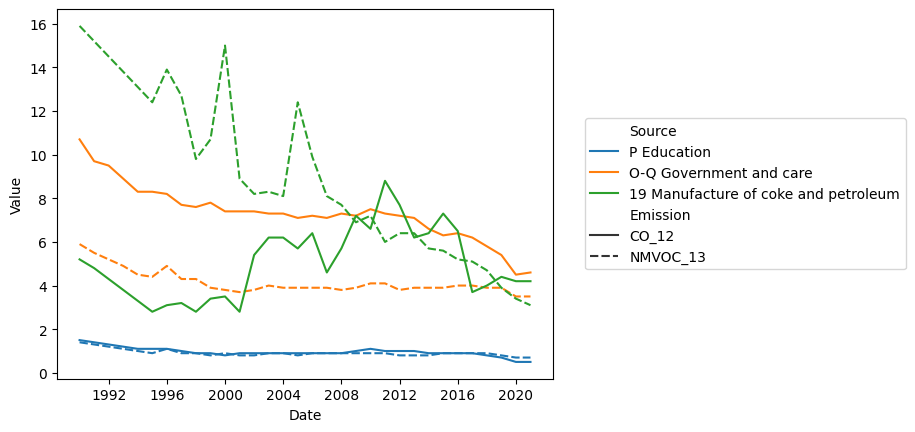

In [55]:
gwp.plot(emission=['CO_12', 'NMVOC_13'],source=['education', 'government','320000' ]);


#### 4) Emission categories [1p]

There are 4 categories of emissions:
   - Greenhouse gases (climate change) {TotalCO2_1, CO2ExclBiomass_2, CO2Biomass_3, N2O_4, CH4_5, GreenhouseGasEquivalents_6}
   - Acidification {NOx_7, SO2_8, NH3_9, AcidificationEquivalents_10}
   - Ozone layer depletion {CFK12Equivalents_11}
   - Other air pollution {CO_12, NMVOC_13, PM10_14, HFC}

Implement the method `get_emission` with the following specification:

**Synopsis:** &nbsp; &nbsp;**<tt>GWP.get_emission(emission_category)</tt>**

   - emission_category : {ghg, acid, ozone, air}
   - return value : list of variable names of the given category.


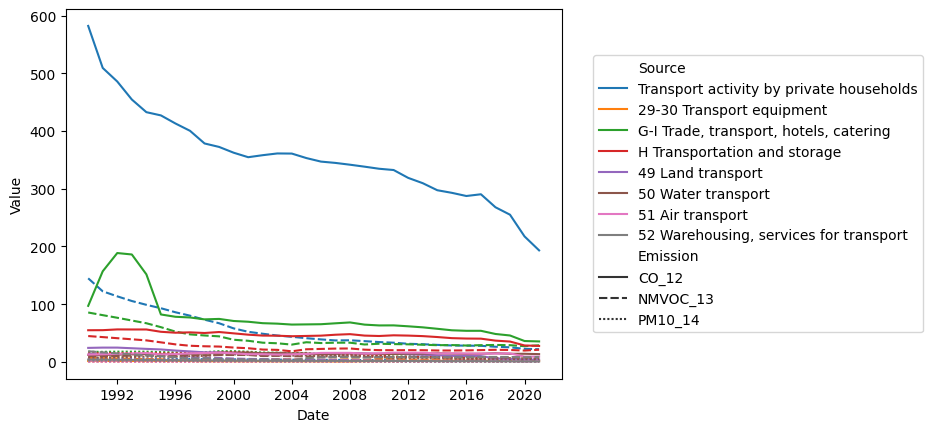

In [61]:
gwp.plot(emission=gwp.get_emission('air'),source=['transport']);

#### 5) Summary [1p]

Implement the `summary` method which gives `general information` about the data such as:
- data and meta file paths
- shape of the data
- number of emission sources.
- number of emission variables
- first and latest date


**Synopsis:** &nbsp; &nbsp;**<tt>GWP.summary(date)</tt>**
   - `date`     : tuple of dates (min,[max]).

If `date` is given then print a DataFrame of descriptive statistics with columns {min, 1st quartile, 2nd quartile, mean 3rd quartile, max} and emission as row indices. In this case do not output the `general information`. Note, for the `date` method argument, in case 'max' is omitted then the summary is given for a single year.


#### 6) Bonus point

Add a new plot method to the class which gives a different kind of information than the one given in GWP.plot.